In [1]:
#Mounting Google Drive Locally

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#set google drive path from personal google drive
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [3]:
# Import the dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score

#warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
#import Data
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv_folder/talking_data.csv', parse_dates = ['click_time'])
data.head()
#Note:use parse_dates for 'click_time' column to use dt. accesories 

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [6]:
#checking target values of download versus no app download
data['is_attributed'].value_counts()
#people rarely download after advertisement

0    99773
1      227
Name: is_attributed, dtype: int64

**Atribute Information**

The detailed data dictionary is mentioned here:


1.   ip: ip address of click. 
2.   app: app id for marketing.
3. device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
4. os: os version id of user mobile phone.
5. channel: channel id of mobile ad publisher.
6. click_time: timestamp of click (UTC)
7. attributed_time: if user download the app for after clicking an ad, this is the time of the app download.
8. is_attributed: the target that is to be predicted, indicating the app was downloaded.

**EDA**

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ip               100000 non-null  int64         
 1   app              100000 non-null  int64         
 2   device           100000 non-null  int64         
 3   os               100000 non-null  int64         
 4   channel          100000 non-null  int64         
 5   click_time       100000 non-null  datetime64[ns]
 6   attributed_time  227 non-null     object        
 7   is_attributed    100000 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 6.1+ MB


In [8]:
#Identifing missing Values
miss_val = data.isna().sum()
miss_val

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

In [9]:
#Unique Values in the data frame

def fraction_unique(x):
    return len(data[x].unique())

number_unique_vals={x:fraction_unique(x) for x in data.columns}

number_unique_vals

#'click_time' has the highest volume of unique values

{'app': 161,
 'attributed_time': 228,
 'channel': 161,
 'click_time': 80350,
 'device': 100,
 'ip': 34857,
 'is_attributed': 2,
 'os': 130}

In [10]:
#This will create a one column data frame for which the 'app' column 
#will have boolean statements True/Flase base on a condition that the values 
#counts are greater than 1%, then it'll show value counts.
print((data['app'].value_counts()/100000 > 0.01).value_counts())
print('---------------------------------------------')

#creates a series with unique values that meet the conditions
#by deleting all rows  from that one column that don't meet conditions.
df= data['app'].value_counts()/100000 > 0.01
df.drop(df[df == False].index, inplace=True)
df.index

False    145
True      16
Name: app, dtype: int64
---------------------------------------------


Int64Index([3, 12, 2, 9, 15, 18, 14, 1, 13, 8, 21, 11, 26, 23, 6, 64], dtype='int64')

In [11]:
#gets rid all rows that have 'app' that don't meet conditions

data2=data.loc[data['app'].isin([3, 12, 2, 9, 15, 18, 14, 1, 13, 8, 21, 11, 26, 23, 6, 64])]
data2['app'].value_counts()
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91411 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ip               91411 non-null  int64         
 1   app              91411 non-null  int64         
 2   device           91411 non-null  int64         
 3   os               91411 non-null  int64         
 4   channel          91411 non-null  int64         
 5   click_time       91411 non-null  datetime64[ns]
 6   attributed_time  26 non-null     object        
 7   is_attributed    91411 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 6.3+ MB


In [12]:
#get rid of 'attributed_time' column because it lacks data
data2= data2.drop(['attributed_time'], axis = 1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91411 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ip             91411 non-null  int64         
 1   app            91411 non-null  int64         
 2   device         91411 non-null  int64         
 3   os             91411 non-null  int64         
 4   channel        91411 non-null  int64         
 5   click_time     91411 non-null  datetime64[ns]
 6   is_attributed  91411 non-null  int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 5.6 MB


In [13]:
# Creating features from click_time
data2['cl_year'] = data2['click_time'].dt.year.astype('int64')
data2['cl_month'] = data2['click_time'].dt.month.astype('int64')
data2['cl_day'] = data2['click_time'].dt.day.astype('int64')
data2['cl_hour'] = data2['click_time'].dt.hour.astype('int64')
data2['cl_minute'] = data2['click_time'].dt.minute.astype('int64')
data2['cl_second'] = data2['click_time'].dt.second.astype('int64')

data2.head()

,ip,app,device,os,channel,click_time,is_attributed,cl_year,cl_month,cl_day,cl_hour,cl_minute,cl_second
0,87540,12,1,13,497,2017-11-07 09:30:38,0,2017,11,7,9,30,38
2,101424,12,1,19,212,2017-11-07 18:05:24,0,2017,11,7,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,0,2017,11,7,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,0,2017,11,9,9,0,9
5,93663,3,1,17,115,2017-11-09 01:22:13,0,2017,11,9,1,22,13


In [14]:
#check to make sure all date times have data
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91411 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ip             91411 non-null  int64         
 1   app            91411 non-null  int64         
 2   device         91411 non-null  int64         
 3   os             91411 non-null  int64         
 4   channel        91411 non-null  int64         
 5   click_time     91411 non-null  datetime64[ns]
 6   is_attributed  91411 non-null  int64         
 7   cl_year        91411 non-null  int64         
 8   cl_month       91411 non-null  int64         
 9   cl_day         91411 non-null  int64         
 10  cl_hour        91411 non-null  int64         
 11  cl_minute      91411 non-null  int64         
 12  cl_second      91411 non-null  int64         
dtypes: datetime64[ns](1), int64(12)
memory usage: 9.8 MB


In [15]:
#get rid of 'click_time' column because it lacks data
data2= data2.drop(['click_time'], axis = 1)
data2.info(), data2.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91411 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   ip             91411 non-null  int64
 1   app            91411 non-null  int64
 2   device         91411 non-null  int64
 3   os             91411 non-null  int64
 4   channel        91411 non-null  int64
 5   is_attributed  91411 non-null  int64
 6   cl_year        91411 non-null  int64
 7   cl_month       91411 non-null  int64
 8   cl_day         91411 non-null  int64
 9   cl_hour        91411 non-null  int64
 10  cl_minute      91411 non-null  int64
 11  cl_second      91411 non-null  int64
dtypes: int64(12)
memory usage: 9.1 MB


(None,                   ip           app  ...     cl_minute     cl_second
 count   91411.000000  91411.000000  ...  91411.000000  91411.000000
 mean    90719.794872     10.254991  ...     29.110031     29.783068
 std     69214.135799      8.682855  ...     17.369994     17.229401
 min         9.000000      1.000000  ...      0.000000      0.000000
 25%     40400.000000      3.000000  ...     14.000000     15.000000
 50%     79219.000000     11.000000  ...     29.000000     30.000000
 75%    117867.000000     15.000000  ...     44.000000     45.000000
 max    364757.000000     64.000000  ...     59.000000     59.000000
 
 [8 rows x 12 columns])

**Train Data**


In [16]:
#seperating dependent data vs independent

x = data2.drop(['is_attributed'], axis = 1) #independent
y = data2['is_attributed'] #dependent

print('size of data frame', data2.shape)
print('size of the array x', x.shape)
print('size of the array y', y.shape)

size of data frame (91411, 12)
size of the array x (91411, 11)
size of the array y (91411,)


In [17]:
#Split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

**Random Forest Model**

In [18]:
#Apply the Random forest model and print the accuracy of Random forest Mode
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rfcl = RandomForestClassifier(criterion = 'entropy', class_weight={0:.5,1:.5}, max_depth = 5, min_samples_leaf=5)
rfcl = rfcl.fit(x_train, y_train)
test_pred = rfcl.predict(x_test)
rfcl_score=rfcl.score(x_test , y_test)
print("The Random forest model accuracy is {}".format(rfcl_score))
print("The confusion matrix of Random Forest Model is")
print(metrics.confusion_matrix(y_test,test_pred))

#Check ROC_AUC
print('---------------------------------------------')
auc_rf = roc_auc_score(y_test, rfcl.predict_proba(x_test)[:,1])
print(auc_rf)

The Random forest model accuracy is 0.9996718262867145
The confusion matrix of Random Forest Model is
[[18277     0]
 [    6     0]]
---------------------------------------------
0.6728310627199942


Feature: 0, Score: 0.19475
Feature: 1, Score: 0.11748
Feature: 2, Score: 0.00707
Feature: 3, Score: 0.06495
Feature: 4, Score: 0.19285
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.04521
Feature: 8, Score: 0.13766
Feature: 9, Score: 0.12547
Feature: 10, Score: 0.11457


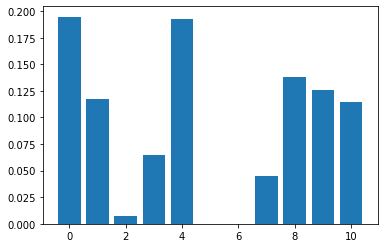

In [19]:
from matplotlib import pyplot
# get importance
importance_rfcl = rfcl.feature_importances_
# summarize feature importance
for i,v in enumerate(importance_rfcl):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance_rfcl))], importance_rfcl)
pyplot.show()

In [20]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91411 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ip         91411 non-null  int64
 1   app        91411 non-null  int64
 2   device     91411 non-null  int64
 3   os         91411 non-null  int64
 4   channel    91411 non-null  int64
 5   cl_year    91411 non-null  int64
 6   cl_month   91411 non-null  int64
 7   cl_day     91411 non-null  int64
 8   cl_hour    91411 non-null  int64
 9   cl_minute  91411 non-null  int64
 10  cl_second  91411 non-null  int64
dtypes: int64(11)
memory usage: 8.4 MB


the best features base of the resultsfrom descending order are:

0: IP

4: Channel

9: cl_minute

3: os

10: cl_seconds

Random forest is used to find importance feutures, this can't be done with bagging 
clasifier but it can be done with xgboost clasifier. Unfortunately my computer isn't 
capable of importing the xgboost library.

**Bagging Classifier**

In [21]:
#Apply Bagging Classifier Algorithm and print the accuracy
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=10, max_samples= .7, bootstrap=True)
bgcl = bgcl.fit(x_train, y_train)
test_pred = bgcl.predict(x_test)
bgcl_score=bgcl.score(x_test, y_test)
print("The Bagging classifier model accuracy is {}".format(bgcl_score))
print("The confusion matrix of Bagging classifier model is")
print(metrics.confusion_matrix(y_test,test_pred))

#bagging classifier doesn't have any features importances atributes

#Check ROC_AUC
print('---------------------------------------------')
auc_bg = roc_auc_score(y_test, bgcl.predict_proba(x_test)[:,1])
print(auc_bg)

The Bagging classifier model accuracy is 0.9996718262867145
The confusion matrix of Bagging classifier model is
[[18277     0]
 [    6     0]]
---------------------------------------------
0.49860480385183564


**XGBoost Clasifier**

In [22]:
#Apply XGBoostClassifier with default parameters on training data and make first 10 prediction for Test data.          
#NOTE: Use y_pred = model.predict_proba(x_test) since we need probabilities to compute AUC.
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

model = XGBClassifier()
model.fit(x_train, y_train)
y_pred = model.predict_proba(x_test)
y_pred[:10]
roc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

#Check ROC_AUC
print('---------------------------------------------')
auc_xg = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
print(auc_xg)

AUC: 57.35%
---------------------------------------------
0.5734529736827707


Feature: 0, Score: 0.13714
Feature: 1, Score: 0.19546
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.12777
Feature: 4, Score: 0.10521
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.10245
Feature: 8, Score: 0.11955
Feature: 9, Score: 0.07142
Feature: 10, Score: 0.14100


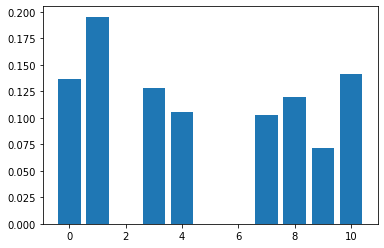

In [23]:
#to get important feutures using XGBoost
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

**Conclusion**

Random Forest, Bagging classifiers, and XGBoost have extremely high accuracy of 99% but have low ROC_AOC of around 67%, 50%, and 57% respecfully. 
​

As far as the target value goes, it can predict when the target value is not obtained but it can't predict when the target 
is attributed. This is the result of a very unbalance result where the target value is atributeds less than 1% of the time.
There were zero atributed values in the confusion matrix, but to raise the target atribution, a weight balance strategy will have to be perform thus compromising false errors and accuracy.
